# Galaxy sampling checks

This notebook generates figure 9 of de Sá, Bernardo et al. (2024).

## Imports

In [1]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms
from scipy.stats import norm
from scipy.integrate import quad

import sys
sys.path.append('..')
from src.sfh import GSMF, SFMR, MZR, Corrections
from src.sampling import GalaxyGrid
from src.utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z
from src.constants import LOGE, LN10, GALAXYGRID_DIR_PATH

## Definitions

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [4]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [5]:
logm_min = 6
logm_max = 12

In [6]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [7]:
MZR_option = midmet_MZR
SFMR_option = midmet_SFMR
GSMF_option = midmet_GSMF_fixedslope
file_suffix = '_midmet'

Note that, due to the way the GalaxyGrid class is currently implemented, when sampling with scatter, the total size of the grid of galaxies from which the sample is drawn will be ``(n_redshift*5)*(logm_per_redshift*10)``. The sample itself will have size ``logm_per_redshift*10``. The ``force_boundary_redshift`` parameter does not affect sampling with scatter because, due to the scatter, there is no one-to-one relationship between metallicity-SFR pairs and redshift.

In [8]:
n_redshift = 10
redshift_min = 0
redshift_max = 10
force_boundary_redshift = True
logm_min = 6
logm_max = 12
logm_per_redshift = 10
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'sfr' # uniform, mass or number
scatter_model = 'normal'
apply_igimf_corrections = True
random_state = 42

In [9]:
galaxygrid = GalaxyGrid(n_redshift,
                        redshift_min,
                        redshift_max,
                        force_boundary_redshift,
                        logm_per_redshift,
                        logm_min, 
                        logm_max, 
                        mzr_model, 
                        sfmr_flattening,
                        gsmf_slope_fixed,
                        sampling_mode,
                        scatter_model,
                        apply_igimf_corrections,
                        random_state)

In [10]:
print(galaxygrid.sampling_grid)

None


In [13]:
galaxygrid.sampling_grid.shape

(250000,)

In [11]:
%%time
galaxygrid.get_sample()

/home/lucasmdesa/GitHub/BOSSA/notebooks/../src/utils.py:83: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  [FeH] = fsolve(_FeH_from_ZOH, np.array([-1]), args=ZOH)


SAMPLING GRID CREATED WITH SHAPE {self.sampling_grid.shape}


/home/lucasmdesa/GitHub/BOSSA/notebooks/../src/sampling.py:1336: RuntimeWarning: divide by zero encountered in log10
  self.sampling_grid_logsfrd_overlay[row, col] = np.log10(sfrd)


UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.VoidDType'>, <class 'numpy.dtypes.VoidDType'>) -> None

Below we generate constant redshift lines (without scatter) as a guideline for reading the post. When sampling with scatter, these lines still represent the mean metallicity and SFR at fixed redshift.

In [11]:
def get_sample(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf):
    sfmr = SFMR(redshift=redshift,
                flattening=flattening,
                scatter_model=scatter_model)
    mzr = MZR(redshift=redshift,
              model=MZR_option,
              scatter_model=scatter_model)
    mzr.set_params()
    
    logsfr = sfmr.logsfr(logm)
    sfr = 10.**logsfr
    zoh = mzr.zoh(logm)
    feh = np.array([ZOH_to_FeH(x) for x in zoh])
    
    if igimf:
        corrections = Corrections(feh, np.tile(logsfr.reshape((logsfr.shape[0], 1)), (1,feh.shape[0])))
        corrections.load_data()
        try:
            corr = np.diag(corrections.get_corrections())
        except ValueError:
            corr = np.tile(np.nan, sfr.shape[0])
        sfr *= 10.**corr
    
    return sfr, zoh

In [12]:
# Scatterless constant redshift curves

scatterless_model_settings = {
    'flattening': SFMR_option,
    'fixed_slope': GSMF_option,
    'mzr_model': MZR_option,
    'scatter_model': 'none',
    'igimf': True
}

guideline_redshifts = np.arange(0, 11, 1)
guideline_logms = np.linspace(6, 12, 30)
redshift_guide_plot = np.zeros((guideline_redshifts.shape[0], 2, guideline_logms.shape[0]))
for i, z in enumerate(guideline_redshifts):
    for j, logm in enumerate(guideline_logms):
        redshift_guide_plot[i, 1, j], redshift_guide_plot[i, 0, j] = get_sample([logm], z, **scatterless_model_settings)    
        redshift_guide_plot[i, 1, j] = np.log10(redshift_guide_plot[i, 1, j])

/tmp/ipykernel_13084/744486128.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  redshift_guide_plot[i, 1, j], redshift_guide_plot[i, 0, j] = get_sample([logm], z, **scatterless_model_settings)


KeyboardInterrupt: 

In [13]:
grid = galaxygrid
colormap = grid.sampling_grid_logsfrd_overlay.T
x = grid.sampling_grid_zoh_axis
y = grid.sampling_grid_logsfr_axis

#minx = np.floor(x.min())
minx = 4.3
#maxx = np.floor(x.max())
maxx = 9.4
#miny = np.floor(y.min())
miny = -3
#maxy = np.floor(y.max())*1.5
maxy = 3.7

fig, ax = plt.subplots(figsize=(22.5,10))#, layout='compressed')
rect = fig.patch
rect.set_facecolor('white')

vmin = colormap[colormap != -np.inf].min()
vmax = colormap[colormap != np.inf].max()

ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)

# Scatterless constant redshift curves
for z, guide_plot in zip(guideline_redshifts, redshift_guide_plot):
    ax.plot(guide_plot[0], guide_plot[1], 'k-')
    if not z%2:
        posx = np.nanmax(guide_plot[0][guide_plot[0] != np.inf])
        posy = np.nanmax(guide_plot[1][guide_plot[1] != np.inf])
        if z <= 2:
            ha = 'left'
            va = 'center'
            posx += 0.05
            posy += 0.2
        else:
            ha = 'center'
            va = 'bottom'
            posy += 0.2
        ax.text(posx, posy+0.2, f'$z={z}$', fontsize=24, ha=ha, va=va)

# Sample
ax.plot(np.concatenate(grid.zoh_list), np.concatenate(grid.sfr_list), color='r', linestyle='none', marker='+', markersize=14)

# SFR axis
ax.set_ylim(miny, maxy)

# Z_O/H axis
ax.set_xlim(minx, maxx)
xticks = np.arange(np.ceil(minx), np.ceil(maxx), 1)
xticklabels = [f'{x:.0f}' for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# [Fe/H] axis
feh_ax = ax.twiny()
feh_ax.set_xlim(ax.get_xlim())
feh_ax.set_xticks(xticks)
feh_ax_labels = [ZOH_to_FeH(x) for x in xticks]
feh_ax.set_xticklabels([f'{x:.2f}' for x in feh_ax_labels])

# Z guidelines
z_guidelines_fehs = np.arange(np.ceil(min(feh_ax_labels)), np.ceil(max(feh_ax_labels)), 1)
z_guidelines_zohs = np.array([ZOH_from_FeH(x) for x in z_guidelines_fehs])
for feh, zoh in zip(z_guidelines_fehs, z_guidelines_zohs):
    ax.vlines(zoh, miny, maxy, color='orange', linestyle='--')
    ax.text(zoh+0.01, 0, f'$10^{{{feh:.0f}}}\\mathrm{{Z}}_\\odot$', va='bottom', ha='left', color='orange',
           transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), fontsize=22)


ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
feh_ax.set_xlabel(r'$\mathrm{[Fe/H]}$')

# Colorbar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='7%', pad='2%')
sm = cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis')
cb = fig.colorbar(sm, ax=ax, fraction=0.05, aspect=20, pad=0.01)
cb.set_label(r'$\log\left[\mathrm{SFRD}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

AttributeError: 'NoneType' object has no attribute 'T'

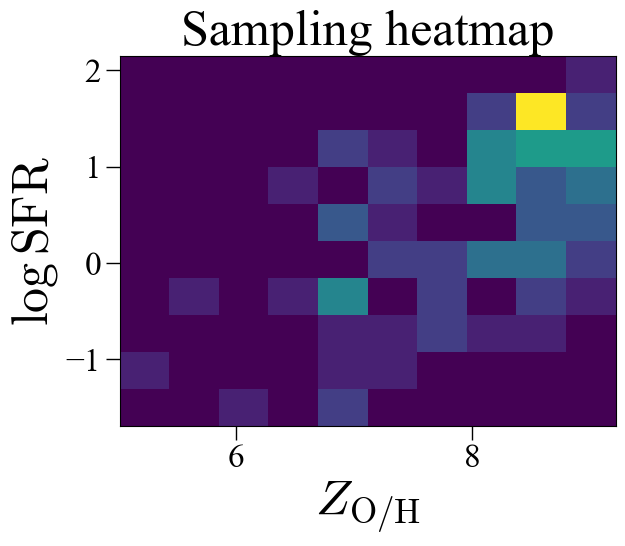

In [14]:
plt.hist2d(np.concatenate(grid.zoh_list), np.concatenate(grid.sfr_list))
plt.xlabel('$Z_\\mathrm{O/H}$')
plt.ylabel('$\\log\\mathrm{SFR}$')
plt.title('Sampling heatmap');

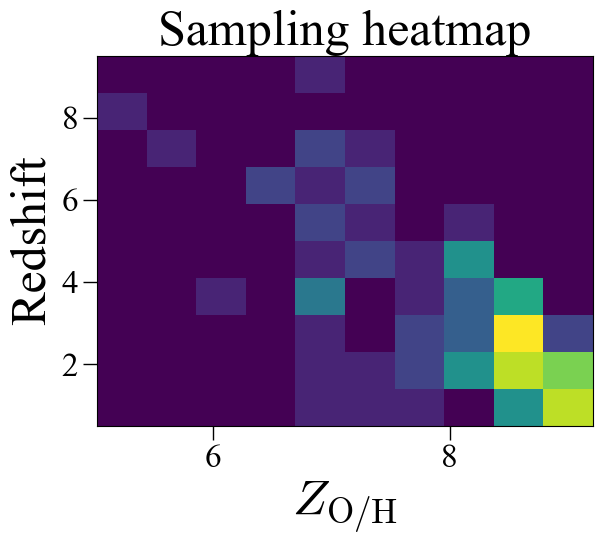

In [15]:
plt.hist2d(np.concatenate(grid.zoh_list), np.concatenate(grid.redshift_list))
plt.xlabel('$Z_\\mathrm{O/H}$')
plt.ylabel('Redshift')
plt.title('Sampling heatmap');

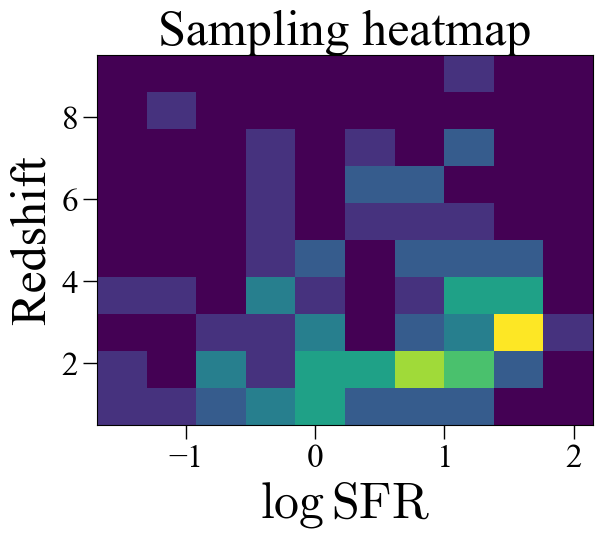

In [16]:
plt.hist2d(np.concatenate(grid.sfr_list), np.concatenate(grid.redshift_list))
plt.xlabel('$\\log\\mathrm{SFR}$')
plt.ylabel('Redshift')
plt.title('Sampling heatmap');

# A complete sampling plot

Let's add an example plot of the redshift distribution within each SFR-metallicity bin.

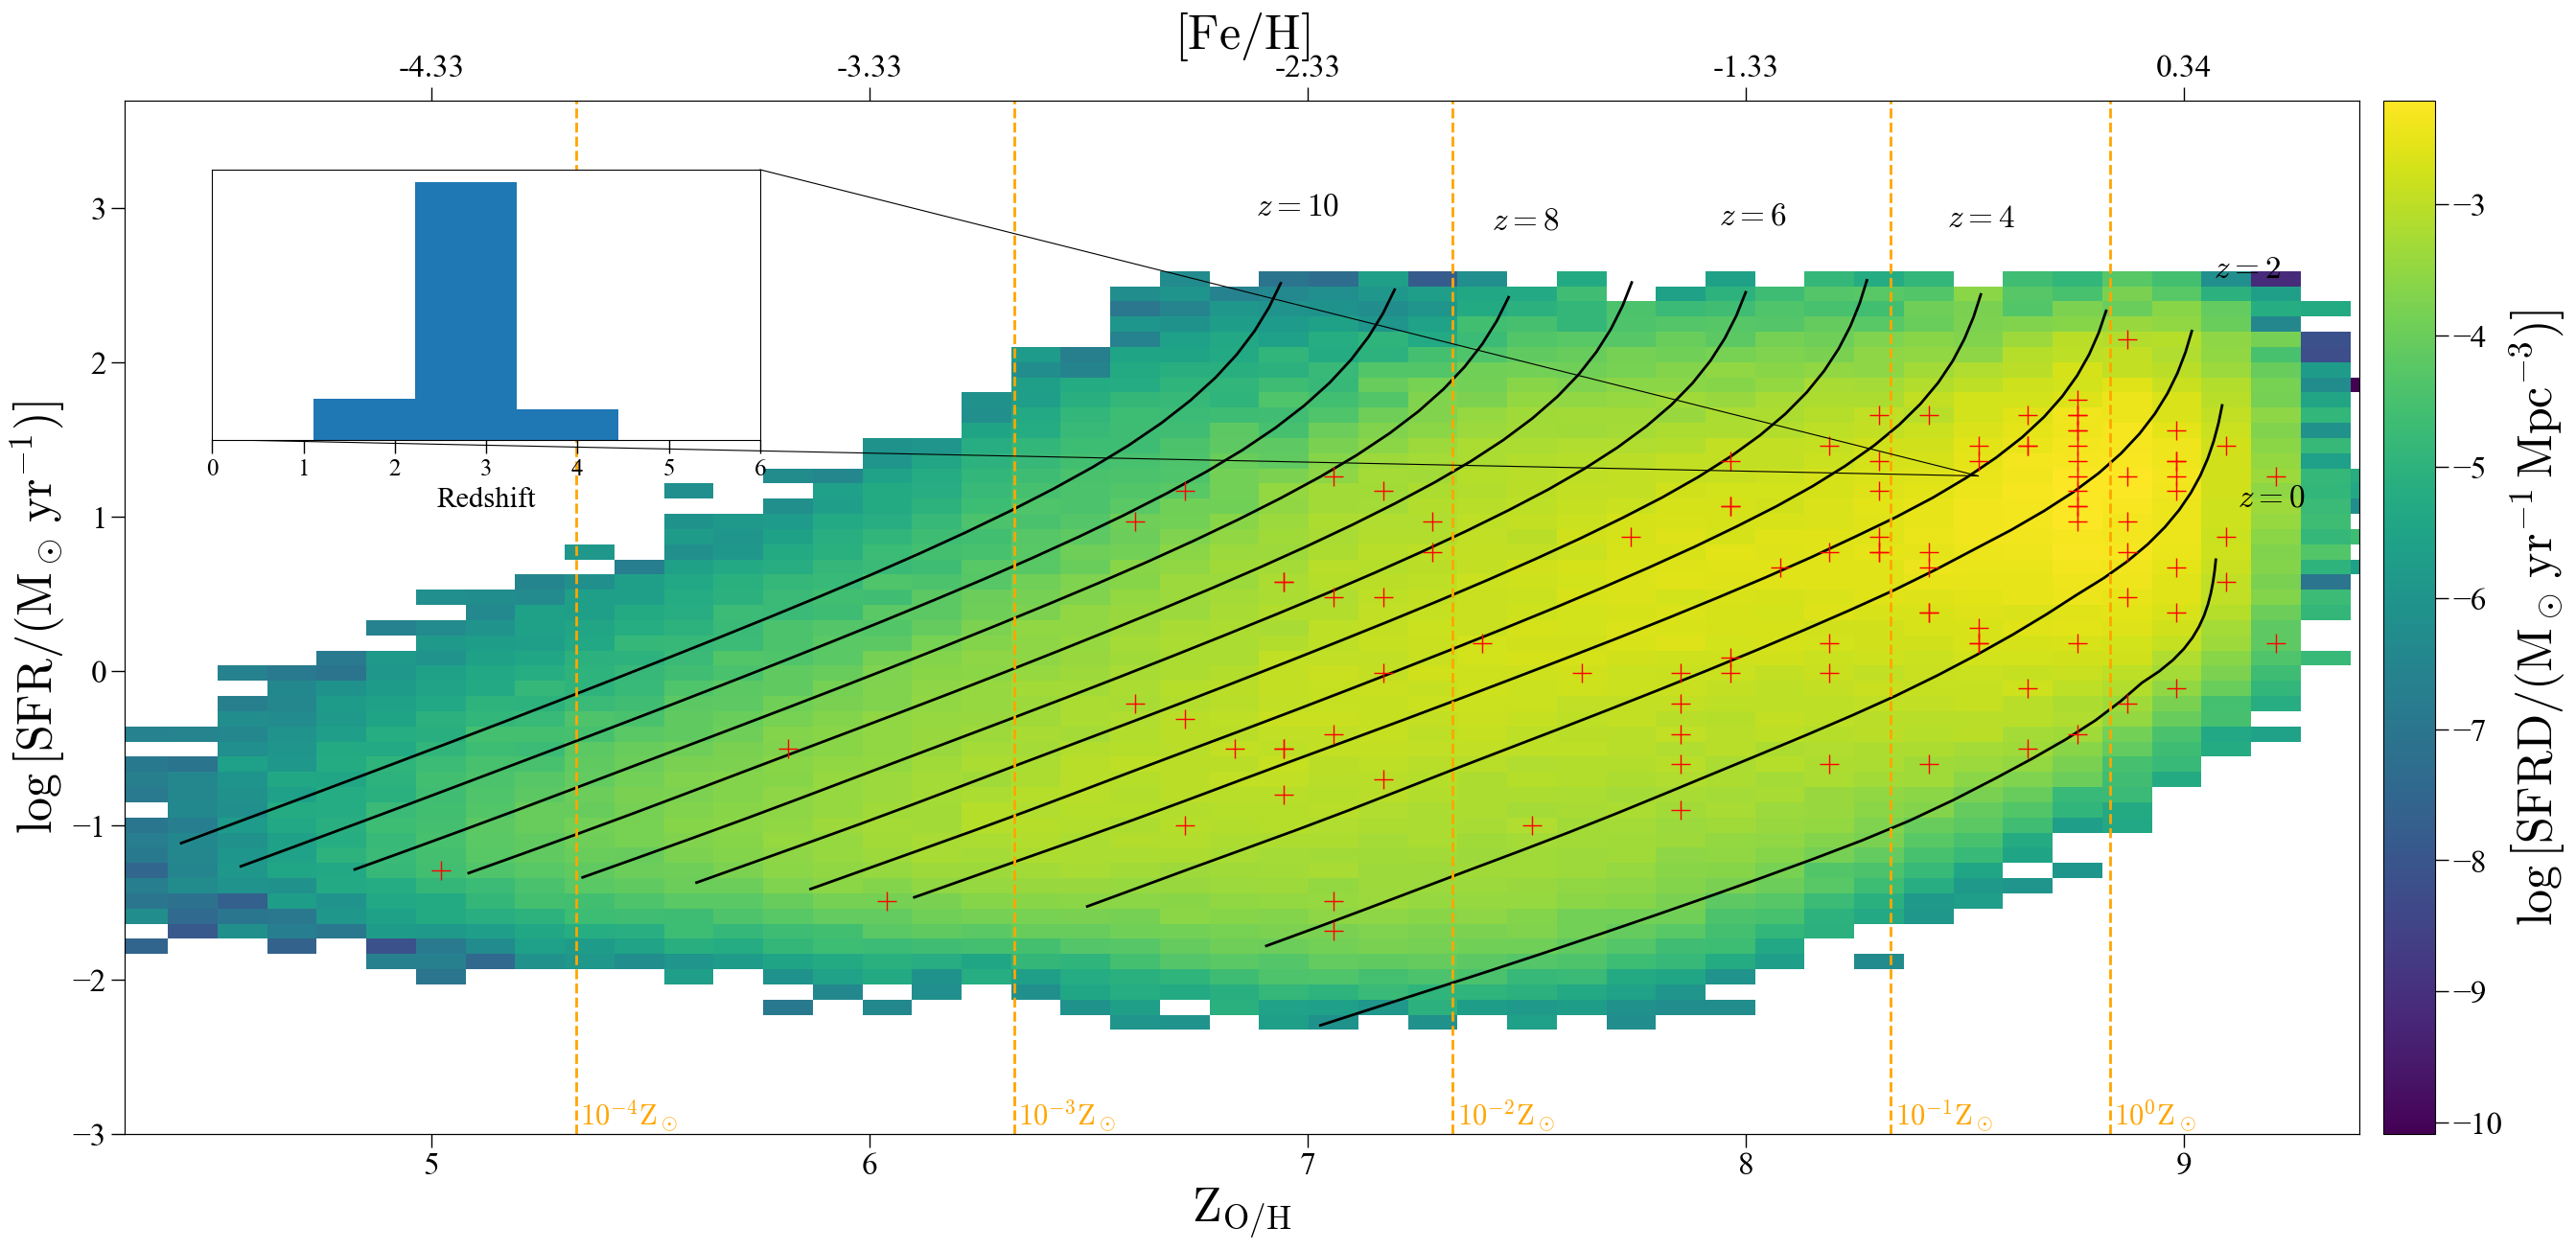

In [17]:
grid = galaxygrid
colormap = grid.sampling_grid_logsfrd_overlay.T
x = grid.sampling_grid_zoh_axis
y = grid.sampling_grid_logsfr_axis

#minx = np.floor(x.min())
minx = 4.3
#maxx = np.floor(x.max())
maxx = 9.4
#miny = np.floor(y.min())
miny = -3
#maxy = np.floor(y.max())*1.5
maxy = 3.7

fig, ax = plt.subplots(figsize=(32,14))#, layout='compressed')
rect = fig.patch
rect.set_facecolor('white')

vmin = colormap[colormap != -np.inf].min()
vmax = colormap[colormap != np.inf].max()

ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)

# Scatterless constant redshift curves
for z, guide_plot in zip(guideline_redshifts, redshift_guide_plot):
    ax.plot(guide_plot[0], guide_plot[1], 'k-')
    if not z%2:
        posx = np.nanmax(guide_plot[0][guide_plot[0] != np.inf])
        posy = np.nanmax(guide_plot[1][guide_plot[1] != np.inf])
        if z <= 2:
            ha = 'left'
            va = 'center'
            posx += 0.05
            posy += 0.2
        else:
            ha = 'center'
            va = 'bottom'
            posy += 0.2
        ax.text(posx, posy+0.2, f'$z={z}$', fontsize=24, ha=ha, va=va)

# Sample
ax.plot(np.concatenate(grid.zoh_list), np.concatenate(grid.sfr_list), color='r', linestyle='none', marker='+', markersize=14)

# SFR axis
ax.set_ylim(miny, maxy)

# Z_O/H axis
ax.set_xlim(minx, maxx)
xticks = np.arange(np.ceil(minx), np.ceil(maxx), 1)
xticklabels = [f'{x:.0f}' for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# [Fe/H] axis
feh_ax = ax.twiny()
feh_ax.set_xlim(ax.get_xlim())
feh_ax.set_xticks(xticks)
feh_ax_labels = [ZOH_to_FeH(x) for x in xticks]
feh_ax.set_xticklabels([f'{x:.2f}' for x in feh_ax_labels])

# Z guidelines
z_guidelines_fehs = np.arange(np.ceil(min(feh_ax_labels)), np.ceil(max(feh_ax_labels)), 1)
z_guidelines_zohs = np.array([ZOH_from_FeH(x) for x in z_guidelines_fehs])
for feh, zoh in zip(z_guidelines_fehs, z_guidelines_zohs):
    ax.vlines(zoh, miny, maxy, color='orange', linestyle='--')
    ax.text(zoh+0.01, 0, f'$10^{{{feh:.0f}}}\\mathrm{{Z}}_\\odot$', va='bottom', ha='left', color='orange',
           transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), fontsize=22)


ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
feh_ax.set_xlabel(r'$\mathrm{[Fe/H]}$')

# Colorbar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='7%', pad='2%')
sm = cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis')
cb = fig.colorbar(sm, ax=ax, fraction=0.05, aspect=20, pad=0.01)
cb.set_label(r'$\log\left[\mathrm{SFRD}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

#### INSET
# For an example plot of the redshift distribution within a SFR-metallicity bin
inset_x = 4.5
inset_y = 1.5
inset_width = 1.25
inset_height = 1.75
inset_ax = ax.inset_axes(
   [inset_x, inset_y, inset_width, inset_height],  # [x, y, width, height] w.r.t. axes
    transform=ax.transData
)

# Choose the most likely bin (highest SFRD) as the exmaple bin.
example_bin_i = np.argmax(colormap.ravel())
bin_y_i = (1+example_bin_i)//len(x)
bin_x_i = len(x) - (1+example_bin_i)%len(x) - 1
bin_y = (y[bin_y_i+1]+y[bin_y_i])/2
bin_x = (x[bin_x_i+1]+x[bin_x_i])/2

# Indicate the bin from which the redshift distribution is taken
ax.plot([bin_x, inset_x], [bin_y, inset_y], 'k-', lw=0.8)
ax.plot([bin_x, inset_x+inset_width], [bin_y, inset_y+inset_height], 'k-', lw=0.8)

# Collect redshifts and plot histogram.
_bin_redshifts = grid.sampling_grid[np.logical_and(
    np.logical_and(grid.sampling_grid[:]['zoh'] >= x[bin_x_i],
                   grid.sampling_grid[:]['zoh'] < x[bin_x_i+1]),
    np.logical_and(grid.sampling_grid[:]['logsfr'] >= y[bin_y_i],
                   grid.sampling_grid[:]['logsfr'] < y[bin_y_i+1])
)][:]['redshift']
inset_ax.hist(_bin_redshifts, bins=np.linspace(redshift_min, redshift_max, 10), density=True, align='mid')#, stacked=True)
inset_ax.set_xlabel('Redshift', fontsize=22)
inset_ax.set_xlim(redshift_min, np.ceil(_bin_redshifts.max())+1)
inset_ax.set_yticks([])
inset_ax.tick_params(labelsize=18)

Now let's complete the figure with the redshift heatmaps

In [70]:
colormap.ravel()[example_bin_i]

-0.2529205008128632

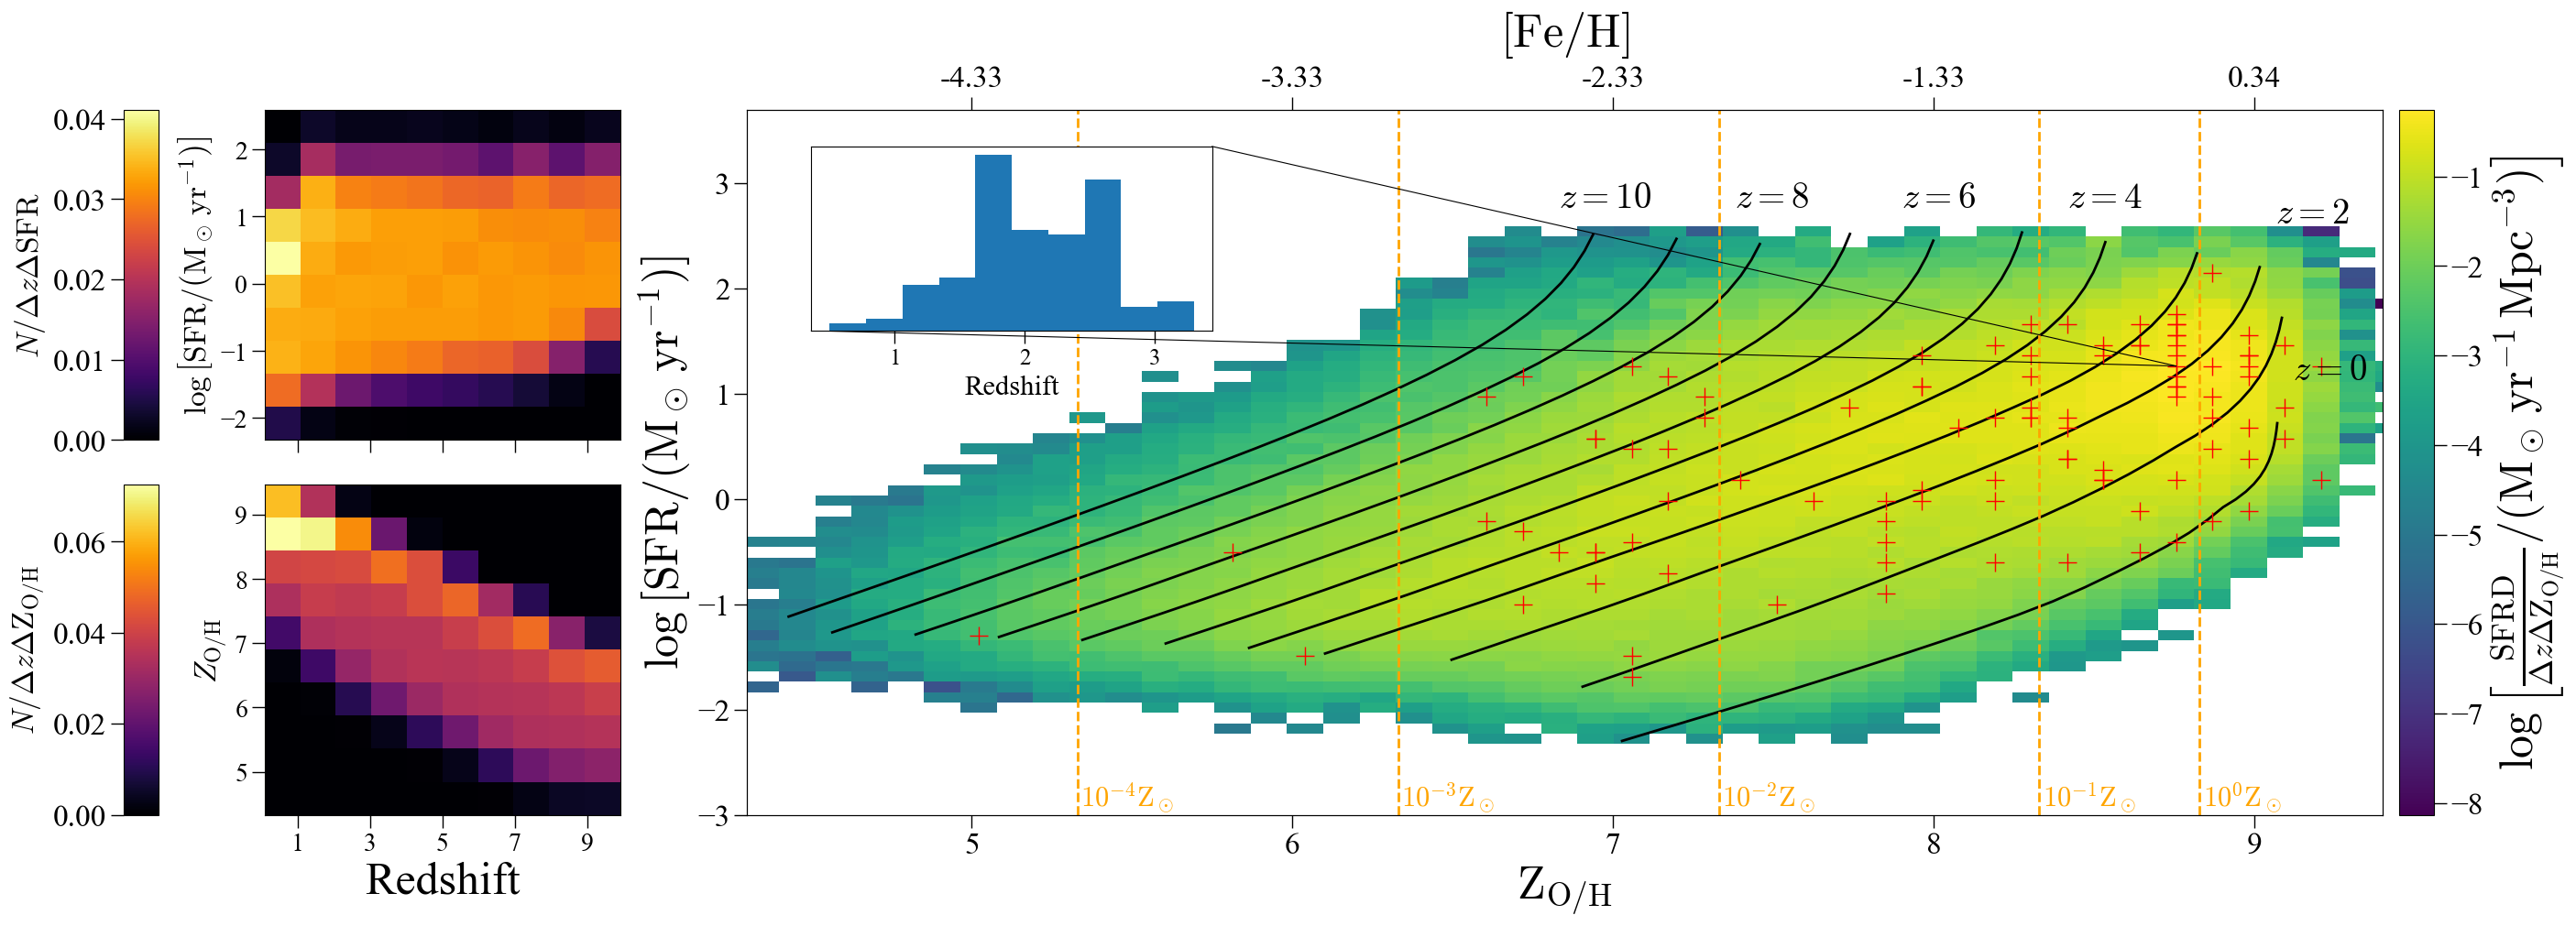

In [80]:
fig = plt.figure(figsize=(28, 10), constrained_layout=True)
gs = fig.add_gridspec(ncols=3, nrows=2, height_ratios = [1, 1], width_ratios=[0.1, 1, (28-5)/5])

sfrd_ax = fig.add_subplot(gs[:, 2])
zoh_z_ax = fig.add_subplot(gs[1, 1])
sfr_z_ax = fig.add_subplot(gs[0, 1], sharex=zoh_z_ax)
sfr_cbar_ax = fig.add_subplot(gs[0, 0])
zoh_cbar_ax = fig.add_subplot(gs[1, 0])

### SFRD PLOT ####
ax = sfrd_ax

grid = galaxygrid
x = grid.sampling_grid_zoh_axis
y = grid.sampling_grid_logsfr_axis
x_deltas = np.array([x1-x0 for x0, x1 in zip(x[:-1], x[1:])])
y_deltas = np.array([y1-y0 for y0, y1 in zip(y[:-1], y[1:])])
deltamap = np.outer(x_deltas, y_deltas)
colormap = grid.sampling_grid_logsfrd_overlay.T - np.log10(deltamap)


#minx = np.floor(x.min())
minx = 4.3
#maxx = np.floor(x.max())
maxx = 9.4
#miny = np.floor(y.min())
miny = -3
#maxy = np.floor(y.max())*1.5
maxy = 3.7

vmin = colormap[colormap != -np.inf].min()
vmax = colormap[colormap != np.inf].max()

ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)

# Scatterless constant redshift curves
last_posy = np.inf
for z, guide_plot in zip(guideline_redshifts, redshift_guide_plot):
    ax.plot(guide_plot[0], guide_plot[1], 'k-')
    if not z%2:
        posx = np.nanmax(guide_plot[0][guide_plot[0] != np.inf])
        posy = np.nanmax(guide_plot[1][guide_plot[1] != np.inf]) + 0.5
        if z <= 2:
            ha = 'left'
            va = 'center'
            posx += 0.05
            posy += 0
        else:
            ha = 'center'
            va = 'bottom'
            posy += 0.2
        if np.abs(posy-last_posy) < 1:
            posy = last_posy
        ax.text(posx, posy, f'$z={z}$', fontsize=28, ha=ha, va=va)
    last_posy = posy

# Sample
ax.plot(np.concatenate(grid.zoh_list), np.concatenate(grid.sfr_list), color='r', linestyle='none', marker='+', markersize=14)

# SFR axis
ax.set_ylim(miny, maxy)

# Z_O/H axis
ax.set_xlim(minx, maxx)
xticks = np.arange(np.ceil(minx), np.ceil(maxx), 1)
xticklabels = [f'{x:.0f}' for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# [Fe/H] axis
feh_ax = ax.twiny()
feh_ax.set_xlim(ax.get_xlim())
feh_ax.set_xticks(xticks)
feh_ax_labels = [ZOH_to_FeH(x) for x in xticks]
feh_ax.set_xticklabels([f'{x:.2f}' for x in feh_ax_labels])

# Z guidelines
z_guidelines_fehs = np.arange(np.ceil(min(feh_ax_labels)), np.ceil(max(feh_ax_labels)), 1)
z_guidelines_zohs = np.array([ZOH_from_FeH(x) for x in z_guidelines_fehs])
for feh, zoh in zip(z_guidelines_fehs, z_guidelines_zohs):
    ax.vlines(zoh, miny, maxy, color='orange', linestyle='--')
    ax.text(zoh+0.01, 0, f'$10^{{{feh:.0f}}}\\mathrm{{Z}}_\\odot$', va='bottom', ha='left', color='orange',
           transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), fontsize=22)


ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
feh_ax.set_xlabel(r'$\mathrm{[Fe/H]}$', va='bottom')

# Colorbar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='7%', pad='2%')
sm = cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis')
cb = fig.colorbar(sm, ax=ax, fraction=0.05, aspect=20, pad=0.01)
cb.set_label(r'$\log\left[\frac{\mathrm{SFRD}}{\Delta z \Delta \mathrm{Z}_\mathrm{O/H}}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

#### INSET
# For an example plot of the redshift distribution within a SFR-metallicity bin
inset_x = 4.5
inset_y = 1.6
inset_width = 1.25
inset_height = 1.75
inset_ax = ax.inset_axes(
   [inset_x, inset_y, inset_width, inset_height],  # [x, y, width, height] w.r.t. axes
    transform=ax.transData
)

# Choose the most likely bin (highest SFRD) as the exmaple bin.
example_bin_i = np.argmax(colormap.ravel())
bin_y_i = (1+example_bin_i)//len(x)
bin_x_i = len(x) - (1+example_bin_i)%len(x) + 1
bin_y = (y[bin_y_i+1]+y[bin_y_i])/2
bin_x = (x[bin_x_i+1]+x[bin_x_i])/2

# Indicate the bin from which the redshift distribution is taken
ax.plot([bin_x, inset_x], [bin_y, inset_y], 'k-', lw=0.8)
ax.plot([bin_x, inset_x+inset_width], [bin_y, inset_y+inset_height], 'k-', lw=0.8)

# Collect redshifts and plot histogram.
_bin_redshifts = grid.sampling_grid[np.logical_and(
    np.logical_and(grid.sampling_grid[:]['zoh'] >= x[bin_x_i],
                   grid.sampling_grid[:]['zoh'] < x[bin_x_i+1]),
    np.logical_and(grid.sampling_grid[:]['logsfr'] >= y[bin_y_i],
                   grid.sampling_grid[:]['logsfr'] < y[bin_y_i+1])
)][:]['redshift']
inset_ax.hist(_bin_redshifts, bins=10, density=True, align='mid')#, stacked=True)
inset_ax.set_xlabel('Redshift', fontsize=22)
#inset_ax.set_xlim(redshift_min, np.ceil(_bin_redshifts.max())+1)
inset_ax.set_yticks([])
inset_ax.tick_params(labelsize=18)

##################
### SFR-REDSHIFT HEATMAP PLOT ###
ax = sfr_z_ax

#sfr_z_hist, *_ = ax.hist2d(np.concatenate(grid.redshift_list), np.concatenate(grid.sfr_list), density=True, cmap='inferno')
plot_grid = grid.sampling_grid[~np.isnan(grid.sampling_grid[:]['logsfr'])]
sfr_z_hist, *_ = ax.hist2d(plot_grid['redshift'], plot_grid['logsfr'], density=True, cmap='inferno')
ax.set_ylabel(r'$\log\left[\mathrm{SFR}/\left(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right)\right]$', fontsize=24)
plt.setp(ax.get_xticklabels(), visible=False)
ax.tick_params(labelsize=20)

# Heatmap colorbar
ax = sfr_cbar_ax
vmin = sfr_z_hist.min()
vmax = sfr_z_hist.max()
sm = cm.ScalarMappable(cmap='inferno', norm=Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, cax=ax, ticklocation='left')
cb.set_label(r'$N/\Delta z\Delta\mathrm{SFR}$', fontsize=24)

##################
### Z_O/H-REDHSIFT HEATMAP PLOT ###
ax = zoh_z_ax
#zoh_z_hist, *_ = ax.hist2d(np.concatenate(grid.redshift_list), np.concatenate(grid.zoh_list), density=True, cmap='inferno')
zoh_z_hist, *_ = ax.hist2d(plot_grid[:]['redshift'], plot_grid[:]['zoh'], density=True, cmap='inferno')
ax.set_ylabel('$Z_\\mathrm{O/H}$', fontsize=24)
ax.set_xlabel('Redshift')
ax.set_xticks(np.arange(np.ceil(np.concatenate(grid.redshift_list).min()), 
                        np.floor(np.concatenate(grid.redshift_list).max())+2, 2))
ax.tick_params(labelsize=20)
# Heatmap colorbar
ax = zoh_cbar_ax
vmin = zoh_z_hist.min()
vmax = zoh_z_hist.max()
sm = cm.ScalarMappable(cmap='inferno', norm=Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, cax=ax, ticklocation='left')
cb.set_label(r'$N/\Delta z\Delta\mathrm{Z}_\mathrm{O/H}$', fontsize=24)

###############
plt.savefig(FIGURE_FOLDER/'scatter_galaxy_sampling_grid.png', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'scatter_galaxy_sampling_grid.pdf', bbox_inches='tight')